### Making a Cleaned CV valid train csv

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
# Load the dataset
df = pd.read_csv('cv-valid-test.csv')

# Drop rows where age or accent is null
df = df.dropna(subset=['age', 'accent'])

# Function to assign a random age based on the category
def assign_random_age(age_group):
    if age_group == 'teens':
        return random.randint(10, 18)
    elif age_group == 'twenties':
        return random.randint(19, 29)
    elif age_group == 'thirties':
        return random.randint(30, 39)
    elif age_group == 'fourties':
        return random.randint(40, 49)
    elif age_group == 'fifties':
        return random.randint(50, 59)
    elif age_group == 'sixties':
        return random.randint(60, 69)
    elif age_group == 'seventies':
        return random.randint(70, 79)
    elif age_group == 'eighties':
        return random.randint(80, 89)
    elif age_group == 'nineties':
        return random.randint(90, 99)
    else:
        return np.nan  # Return NaN if the age_group is not recognized

# Apply the function to the 'age' column
df['age'] = df['age'].apply(assign_random_age)

# Save the cleaned data to a new CSV file
df.to_csv('cv-valid-test-cleaned.csv', index=False)

print("Dataset cleaned and saved to 'cv-valid-test-cleaned.csv'.")


Dataset cleaned and saved to 'cv-valid-test-cleaned.csv'.


### Making Cleaned Turncated_train.csv file 

In [3]:
# Load the dataset
df = pd.read_csv('truncated_train.csv')

# Drop rows where age, gender, or accent is null
df = df.dropna(subset=['age', 'gender', 'accent'])

# Function to assign a random age based on the category
def assign_random_age(age_group):
    if age_group == 'teens':
        return random.randint(10, 18)
    elif age_group == 'twenties':
        return random.randint(19, 29)
    elif age_group == 'thirties':
        return random.randint(30, 39)
    elif age_group == 'fourties':
        return random.randint(40, 49)
    elif age_group == 'fifties':
        return random.randint(50, 59)
    elif age_group == 'sixties':
        return random.randint(60, 69)
    elif age_group == 'seventies':
        return random.randint(70, 79)
    elif age_group == 'eighties':
        return random.randint(80, 89)
    elif age_group == 'nineties':
        return random.randint(90, 99)
    else:
        return np.nan  # Return NaN if the age_group is not recognized

# Apply the function to the 'age' column
df['age'] = df['age'].apply(assign_random_age)

# Save the cleaned data to a new CSV file
df.to_csv('cleaned_truncated_train.csv', index=False)

print("Dataset cleaned and saved to 'cleaned_truncated_train.csv'.")


Dataset cleaned and saved to 'cleaned_truncated_train.csv'.


### Load the turncated train audio files using librosa library

In [4]:
import librosa
import os

In [5]:
# Load the dataset
df = pd.read_csv('cleaned_truncated_train.csv')

# Directory where your audio files are stored, adjust as needed
audio_directory = '.'

# Dictionary to store audio data
audio_data = {}

# Load audio files specified in the dataframe
for index, row in df.iterrows():
    audio_path = os.path.join(audio_directory, row['filename'])
    if os.path.exists(audio_path):  # Check if the file exists
        # Load the audio file
        audio, sr = librosa.load(audio_path, sr=None)  # sr=None loads the native sampling rate
        audio_data[row['filename']] = (audio, sr)
    else:
        print(f"File not found: {audio_path}")

print("Audio files loaded successfully.")


Audio files loaded successfully.


### Features Extraction & Data Visualisation

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Features extracted and saved to 'audio_features.csv'.


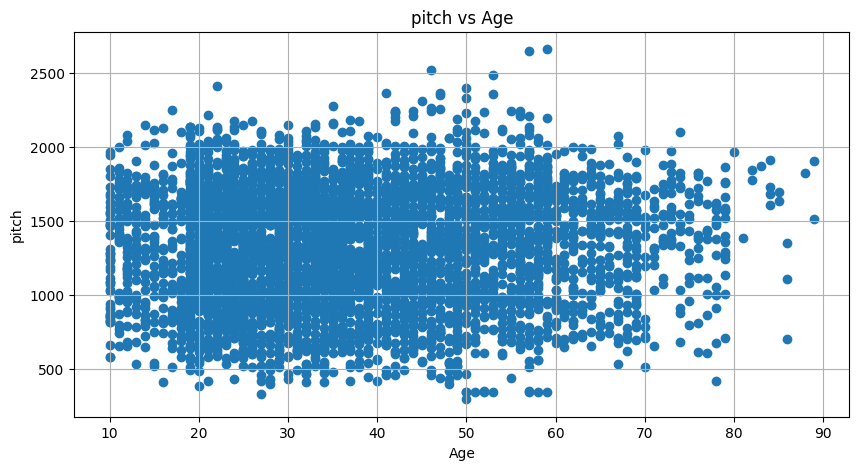

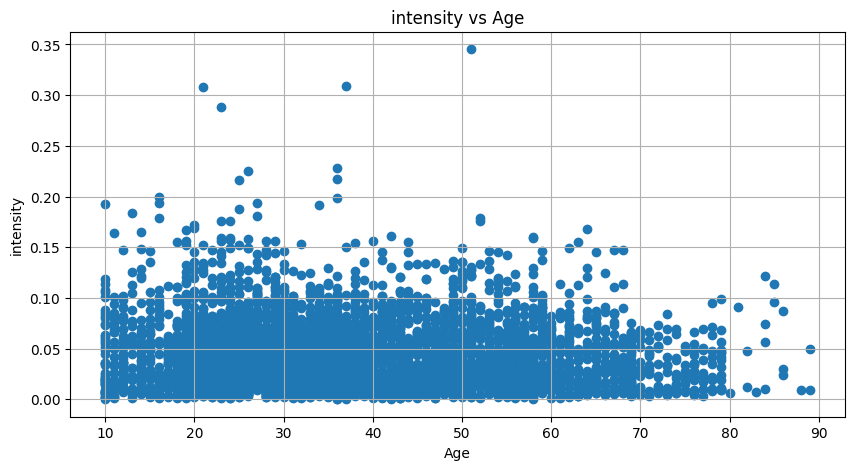

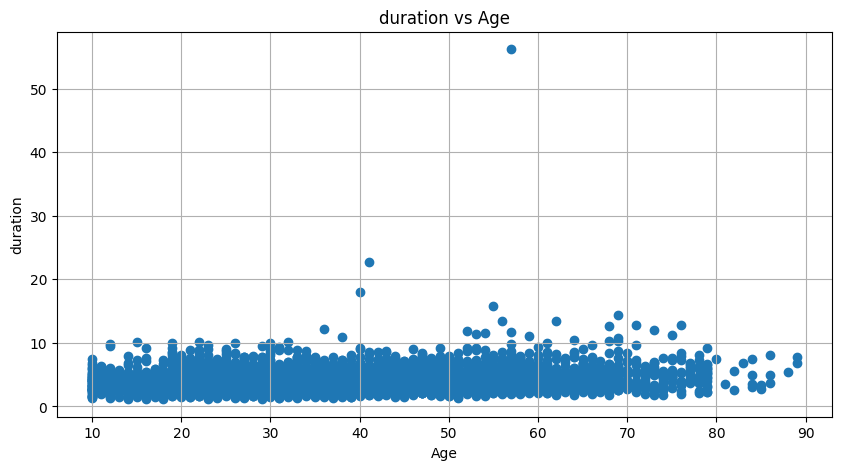

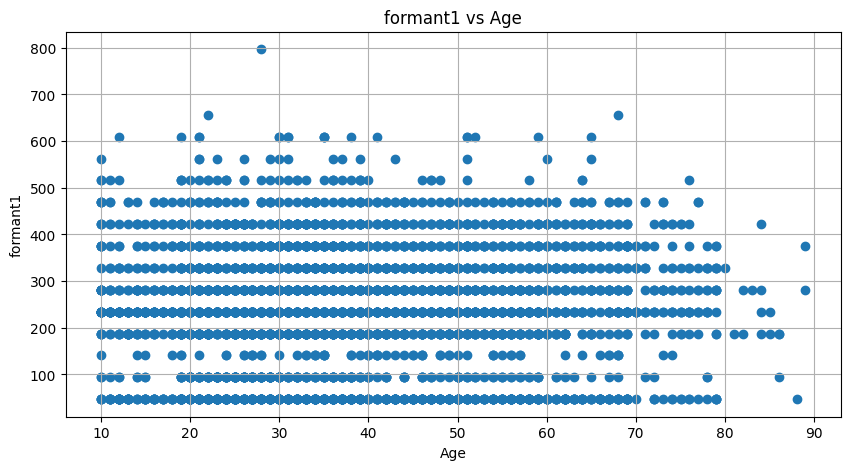

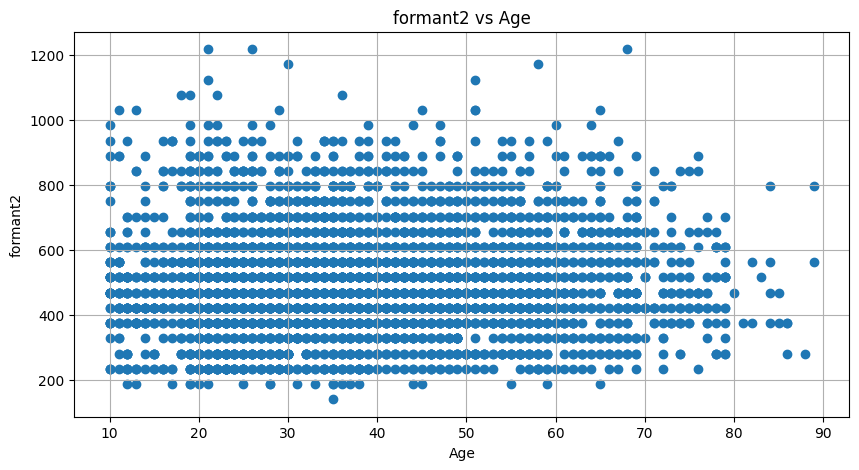

In [10]:
# Load the dataset
df = pd.read_csv('cleaned_truncated_train.csv')

# Directory where your audio files are stored
audio_directory = '.'

# Initialize a list to store features data
features_list = []

# Function to extract features
def extract_features(file_path, age):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)
    # Duration
    duration = librosa.get_duration(y=audio, sr=sr)
    # Pitch
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitch = np.median(pitches[pitches > 0])  # Median pitch excluding zero values
    # Energy
    intensity = np.mean(librosa.feature.rms(y=audio))
    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13) #spectral_features
    mfccs_mean = np.mean(mfccs, axis=1) #axis = 1 --> mean of every row.
    
    # Assuming the first two formant frequencies are required
    # Get Spectrogram
    D = np.abs(librosa.stft(audio))
    # Find peaks in the first (lower) part of the spectrum
    peaks, _ = find_peaks(D[:50].mean(axis=1), height=0)
    formant_frequencies = peaks[:2] * sr / 1024  # Convert bins to Hz
    
    return [age, duration, pitch, intensity, *formant_frequencies, *mfccs_mean]

# Extract features for each audio file
for index, row in df.iterrows():
    file_path = os.path.join(audio_directory, row['filename'])
    if os.path.exists(file_path):
        feature_vector = extract_features(file_path, row['age'])
        features_list.append(feature_vector)
    else:
        print(f"File not found: {file_path}")

# Name the columns including age
feature_names = ['age', 'duration', 'pitch', 'intensity', 'formant1', 'formant2'] + [f'mfcc_{i}' for i in range(1, 14)]
features_df = pd.DataFrame(features_list, columns=feature_names)

# Save features DataFrame
features_df.to_csv('audio_features.csv', index=False)
print("Features extracted and saved to 'audio_features.csv'.")

# Plotting each feature against age
features_to_plot = ['pitch', 'intensity', 'duration', 'formant1', 'formant2']
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    plt.scatter(features_df['age'], features_df[feature])
    plt.title(f'{feature} vs Age')
    plt.xlabel('Age')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


### Model Training 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
from IPython.display import display

In [12]:
# Load the original dataset that contains filenames
original_df = pd.read_csv('cleaned_truncated_train.csv')

# Assuming the rows align perfectly with the audio_features.csv
features_df['filename'] = original_df['filename']

# Save this updated DataFrame if necessary
features_df.to_csv('audio_features_with_filenames.csv', index=False)


In [18]:
def custom_linear_regression(X, y):
    # Add a column of ones to X for the intercept term
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Calculate the coefficients using the normal equation
    coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    # Return the coefficients
    return coefficients

def predict(X, coefficients):
    # Add a column of ones to X for the intercept term
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Return the predictions
    return X.dot(coefficients)

def calculate_accuracy(df, age_mapping, threshold=15):
    correct_predictions = 0
    total_predictions = len(df)

    for index, row in df.iterrows():
        predicted_age = row['predicted_age']
        true_age = row['age']  # Direct use of actual age
        age_group = age_mapping.get(true_age, None)

        if age_group is not None:
            if abs(predicted_age - age_group) <= threshold:
                correct_predictions += 1

    return (correct_predictions / total_predictions) * 100

# Define age mapping for direct use
age_mapping = {i: i for i in range(100)}  # Mapping age directly to itself for simplicity

# Load the features dataset
features_df = pd.read_csv('audio_features_with_filenames.csv')

# Define the features and target variable
X = features_df[['pitch', 'intensity', 'duration', 'formant1', 'formant2']].values
y = features_df['age'].values

# Check if the model coefficients file exists to avoid retraining
model_filename = 'linear_regression_coefficients.pkl'
try:
    with open(model_filename, 'rb') as file:
        coefficients = pickle.load(file)
    print("Model coefficients loaded successfully.")
except FileNotFoundError:
    # Create and compute the model coefficients if not already saved
    coefficients = custom_linear_regression(X, y)
    with open(model_filename, 'wb') as file:
        pickle.dump(coefficients, file)
    print("Model coefficients computed and saved.")

# Make predictions using the loaded or computed coefficients
predictions = predict(X, coefficients)
features_df['predicted_age'] = predictions

# Select relevant columns for display
results_df = features_df[['filename', 'pitch', 'intensity', 'duration', 'formant1', 'formant2', 'predicted_age', 'age']]
print(results_df.to_string(index=False))


# Display in a nice table if using a Jupyter Notebook or similar
display(features_df)

# Calculate and print accuracy
accuracy = calculate_accuracy(features_df, age_mapping)
print(f"Accuracy of Training Model: {accuracy:.2f}%")

Model coefficients loaded successfully.
                        filename      pitch  intensity  duration  formant1  formant2  predicted_age  age
cv-valid-train/sample-000005.mp3  706.46216   0.006549     5.832   375.000   796.875      41.178539   23
cv-valid-train/sample-000008.mp3 1478.27920   0.013888     1.728   421.875   609.375      36.993732   74
cv-valid-train/sample-000013.mp3 1714.86770   0.035668     4.224   375.000   750.000      40.743800   30
cv-valid-train/sample-000014.mp3  532.87090   0.031007     5.376    46.875   328.125      36.826229   67
cv-valid-train/sample-000019.mp3  692.22130   0.043531     3.720   187.500   421.875      35.356824   55
cv-valid-train/sample-000020.mp3 2020.58790   0.082580     5.784   281.250   515.625      41.142602   34
cv-valid-train/sample-000023.mp3 1431.69310   0.058760     3.504   375.000   515.625      37.420067   33
cv-valid-train/sample-000026.mp3 1573.79140   0.103904     4.992   375.000   703.125      39.151599   25
cv-valid-train/

,age,duration,pitch,intensity,formant1,formant2,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,filename,predicted_age
0,23,5.832,706.46216,0.006549,375.000,796.875,-625.28143,111.306145,6.369084,34.767100,...,-4.721564,-0.511934,-4.945490,-12.712850,-2.043671,-3.727725,-10.708405,-11.206564,cv-valid-train/sample-000005.mp3,41.178539
1,74,1.728,1478.27920,0.013888,421.875,609.375,-469.93665,126.283390,-16.548649,3.546792,...,13.748076,-1.324955,-11.255142,-15.318210,-18.646616,-5.582065,-10.987889,1.132519,cv-valid-train/sample-000008.mp3,36.993732
2,30,4.224,1714.86770,0.035668,375.000,750.000,-418.20547,147.666870,-49.974003,-2.286364,...,-8.906048,-14.228477,-12.295596,-18.744495,-3.454832,-3.504616,-13.844883,-9.928527,cv-valid-train/sample-000013.mp3,40.743800
3,67,5.376,532.87090,0.031007,46.875,328.125,-464.91070,118.437225,19.749662,27.143229,...,2.309232,-9.353925,-10.454815,-6.963062,-6.034733,-7.230496,-5.461425,-2.908412,cv-valid-train/sample-000014.mp3,36.826229
4,55,3.720,692.22130,0.043531,187.500,421.875,-343.83300,157.153880,7.661149,41.898964,...,28.925106,0.091127,10.246749,6.509378,6.940933,0.814843,0.102648,6.319802,cv-valid-train/sample-000019.mp3,35.356824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817,41,7.464,743.70200,0.013427,281.250,609.375,-496.35876,101.324510,15.632584,34.921550,...,20.253940,0.838365,4.412111,7.463418,0.520067,4.114404,0.160678,1.122643,cv-valid-train/sample-014993.mp3,42.319814
4818,30,6.696,1426.64950,0.022652,328.125,609.375,-419.76578,107.126730,-2.220559,24.267738,...,17.366467,-19.282873,1.133472,-15.560934,-10.817082,-14.192824,-8.757971,-4.529395,cv-valid-train/sample-014994.mp3,42.996059
4819,31,3.024,1657.86320,0.072386,609.375,890.625,-358.67340,126.730060,2.449768,-0.464527,...,26.451159,-30.614853,16.773232,-11.560968,-2.050642,-1.745537,-6.498254,-9.530166,cv-valid-train/sample-014995.mp3,38.954239
4820,47,4.704,764.28010,0.069570,234.375,468.750,-371.01004,119.170600,19.841621,28.169868,...,29.104855,-10.821848,-8.933249,-7.329440,-5.074921,3.225558,-2.928329,0.982731,cv-valid-train/sample-014998.mp3,36.368323


Accuracy: 63.94%


### Model Evaluation

In [19]:
# Calculate MAE, and R²
mae = mean_absolute_error(features_df['age'], features_df['predicted_age'])
r2 = r2_score(features_df['age'], features_df['predicted_age'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 12.736051273895947
R-squared (R²): 0.03589812124981395



MAE by Age Group:
age_group
0-19     22.087455
20-39     8.646475
40-59    10.963788
60-79    28.009940
80+      44.676488
dtype: float64


C:\Users\Al Syed Computers\AppData\Local\Temp\ipykernel_17328\3749189557.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mae = features_df.groupby('age_group').apply(lambda x: mean_absolute_error(x['age'], x['predicted_age']))
C:\Users\Al Syed Computers\AppData\Local\Temp\ipykernel_17328\3749189557.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mae = features_df.groupby('age_group').apply(lambda x: mean_absolute_error(x['age'], x['predicted_age']))


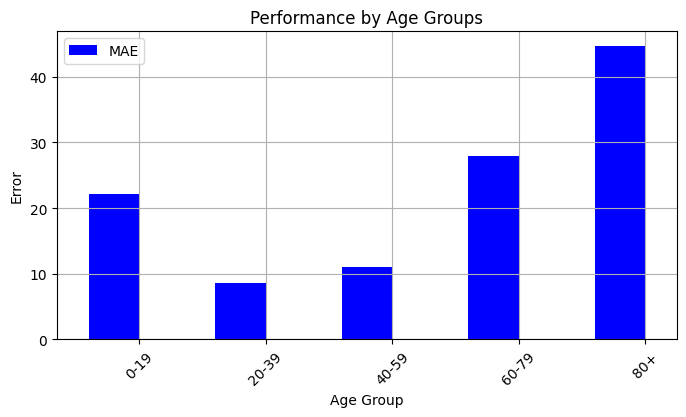

In [20]:
# Define age brackets
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-19', '20-39', '40-59', '60-79', '80+']
features_df['age_group'] = pd.cut(features_df['age'], bins=bins, labels=labels, right=False)

# Calculate MAE for each age group
grouped_mae = features_df.groupby('age_group').apply(lambda x: mean_absolute_error(x['age'], x['predicted_age']))


print("\nMAE by Age Group:")
print(grouped_mae)

# Plotting the results
plt.figure(figsize=(8, 4))
grouped_mae.plot(kind='bar', color='blue', position=1, label='MAE', width=0.4)
plt.title('Performance by Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Error')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Model Testing on CV-Valid-Test

In [24]:
# Load the original dataset that contains filenames
original_df = pd.read_csv('cv-valid-test-cleaned.csv')

# Assuming the rows align perfectly with the audio_features.csv
features_df['filename'] = original_df['filename']

# Save this updated DataFrame if necessary
features_df.to_csv('audio_features_with_filenames2.csv', index=False)

# Load the features dataset
features_df = pd.read_csv('audio_features_with_filenames2.csv')

# Remove rows where filename is NaN
features_df = features_df.dropna(subset=['filename'])

# Define the features and target variable
X = features_df[['pitch', 'intensity', 'duration', 'formant1', 'formant2']].values
y = features_df['age'].values


def calculate_accuracy(df, age_mapping, threshold=15):
    correct_predictions = 0
    total_predictions = len(df)

    for index, row in df.iterrows():
        predicted_age = row['predicted_age']
        true_age = row['age']  # Direct use of actual age
        age_group = age_mapping.get(true_age, None)

        if age_group is not None:
            if abs(predicted_age - age_group) <= threshold:
                correct_predictions += 1

    return (correct_predictions / total_predictions) * 100

# Define age mapping for direct use
age_mapping = {i: i for i in range(100)}  # Mapping age directly to itself for simplicity

# Load model coefficients
model_filename = 'linear_regression_coefficients.pkl'
with open(model_filename, 'rb') as file:
    coefficients = pickle.load(file)
print("Model coefficients loaded successfully.")

# Make predictions using the loaded or computed coefficients
predictions = predict(X, coefficients)
features_df['predicted_age'] = predictions

# Select relevant columns for display
results_df = features_df[['filename', 'pitch', 'intensity', 'duration', 'formant1', 'formant2', 'predicted_age', 'age']]
print(results_df.to_string(index=False))

# Display as a nicer table in Jupyter Notebook or other IPython environments
display(results_df)

# Calculate and print accuracy
accuracy = calculate_accuracy(features_df, age_mapping)
print(f"Accuracy: {accuracy:.2f}%")

Model coefficients loaded successfully.
                       filename      pitch  intensity  duration  formant1  formant2  predicted_age  age
cv-valid-test/sample-000003.mp3  706.46216   0.006549     5.832   375.000   796.875      41.178539   23
cv-valid-test/sample-000005.mp3 1478.27920   0.013888     1.728   421.875   609.375      36.993732   74
cv-valid-test/sample-000008.mp3 1714.86770   0.035668     4.224   375.000   750.000      40.743800   30
cv-valid-test/sample-000009.mp3  532.87090   0.031007     5.376    46.875   328.125      36.826229   67
cv-valid-test/sample-000014.mp3  692.22130   0.043531     3.720   187.500   421.875      35.356824   55
cv-valid-test/sample-000018.mp3 2020.58790   0.082580     5.784   281.250   515.625      41.142602   34
cv-valid-test/sample-000022.mp3 1431.69310   0.058760     3.504   375.000   515.625      37.420067   33
cv-valid-test/sample-000026.mp3 1573.79140   0.103904     4.992   375.000   703.125      39.151599   25
cv-valid-test/sample-000

,filename,pitch,intensity,duration,formant1,formant2,predicted_age,age
0,cv-valid-test/sample-000003.mp3,706.46216,0.006549,5.832,375.000,796.875,41.178539,23
1,cv-valid-test/sample-000005.mp3,1478.27920,0.013888,1.728,421.875,609.375,36.993732,74
2,cv-valid-test/sample-000008.mp3,1714.86770,0.035668,4.224,375.000,750.000,40.743800,30
3,cv-valid-test/sample-000009.mp3,532.87090,0.031007,5.376,46.875,328.125,36.826229,67
4,cv-valid-test/sample-000014.mp3,692.22130,0.043531,3.720,187.500,421.875,35.356824,55
...,...,...,...,...,...,...,...,...
1322,cv-valid-test/sample-003971.mp3,336.43503,0.020357,1.776,234.375,421.875,32.594688,27
1323,cv-valid-test/sample-003975.mp3,799.96630,0.027563,4.560,234.375,421.875,37.357313,75
1324,cv-valid-test/sample-003976.mp3,1692.40480,0.009603,2.400,187.500,328.125,36.998604,29
1325,cv-valid-test/sample-003980.mp3,1093.68680,0.061802,5.496,234.375,468.750,38.559205,40


Accuracy: 62.92%


### Accuracy Function for Model Testing

In [22]:
# Calculate  MAE, and R²
mae = mean_absolute_error(features_df['age'], features_df['predicted_age'])
r2 = r2_score(features_df['age'], features_df['predicted_age'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 12.7673611171233
R-squared (R²): 0.04964485103739391


C:\Users\Al Syed Computers\AppData\Local\Temp\ipykernel_17328\77063310.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mae = features_df.groupby('age_group').apply(lambda x: mean_absolute_error(x['age'], x['predicted_age']))
C:\Users\Al Syed Computers\AppData\Local\Temp\ipykernel_17328\77063310.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mae = features_df.groupby('age_group').apply(lambda x: mean_absolute_error(x['age'], x['predicted_age']))



MAE by Age Group:
age_group
0-19     22.158859
20-39     8.800567
40-59    10.732580
60-79    27.431305
80+      43.526010
dtype: float64


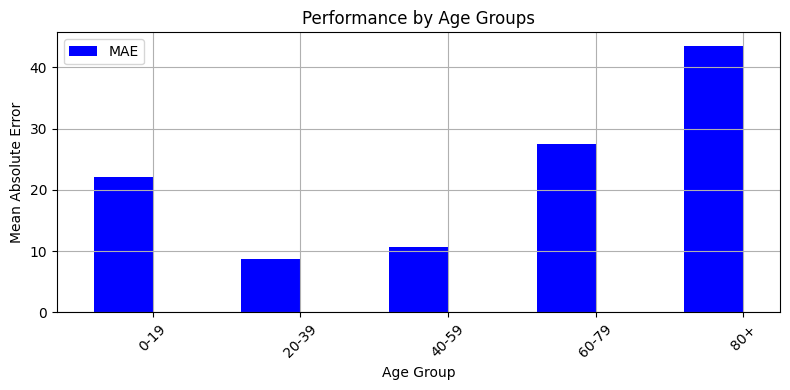

In [23]:
# Define age brackets
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-19', '20-39', '40-59', '60-79', '80+']
features_df['age_group'] = pd.cut(features_df['age'], bins=bins, labels=labels, right=False)

# Check for NaN values which could affect the MAE calculation
if features_df[['age', 'predicted_age']].isnull().any().any():
    print("Warning: NaN values found in 'age' or 'predicted_age'. Results may be skewed.")

# Calculate MAE for each age group
grouped_mae = features_df.groupby('age_group').apply(lambda x: mean_absolute_error(x['age'], x['predicted_age']))


# Calculate R² for each age group
#grouped_r2 = features_df.groupby('age_group').apply(lambda x: r2_score(x['age'], x['predicted_age']))
#print("\nR-squared by Age Group:")
#print(grouped_r2)

print("\nMAE by Age Group:")
print(grouped_mae)

# Plotting the results
plt.figure(figsize=(8, 4))
grouped_mae.plot(kind='bar', color='blue', position=1, label='MAE', width=0.4)

plt.title('Performance by Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()